In [102]:
from keras import layers
from keras import models
from keras import backend
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

class VisionNet:
    model = None
    def __init__ (self,arch,verbose=0,reset=1):
        if (reset):
            print ("INFO: resetting all nodes .. ");
            backend.reset_uids()
            
        # create the model
        self.model = models.Sequential()
        
        # checks
        if (len(arch) < 2):
            raise Exception('insufficient arguments')
            
        if (arch[0][0] != 'input'):
            raise Exception('architecture has no \'input\' entry')
        
        # parse/extract input parameters
        if (len(arch[0][2]) != 2):
            raise Exception('\'input\' entry is incorrect',arch[0])
            
        input_dep = arch[0][1]
        input_len = arch[0][2][0]
        input_wid = arch[0][2][1]
        print("N/Net: Input len=%d wid=%d depth=%d"%(input_len,input_wid,input_dep))
        
        # for each layer of the architecture
        for (indx,val) in enumerate(arch):
            
            # input layer has already been parsed
            if (indx == 0):
                continue
                
            # for layers which only have a name and no parameters (e.g. maxpool)
            if (type(val) == str):
                layer = val
            else:
                layer = val[0]
            
            if (layer == 'conv2d'):
                filters     = val[1]
                kernel_size = (val[2][0],val[2][1])
                act         = val[3]
                print ("CONV::",filters,kernel_size,act)
                
                if (indx==1):
                    self.model.add(layers.Conv2D(filters, kernel_size, activation=act,
                                                 input_shape=(input_len, input_wid, input_dep)))
                else:
                    self.model.add(layers.Conv2D(filters,kernel_size, activation=act))
                                   
            elif (layer == 'maxpool'):
                # use default
                pool_size = (2,2)
                
                print ("MAXP::",pool_size)
                self.model.add(layers.MaxPooling2D(pool_size))
                
            elif (layer == 'flatten'):
                print ("FLAT::")
                self.model.add(layers.Flatten())
              
            elif (layer == 'dropout'):
                drop_pct = val[1]
                print ("DROP::%1.3f"%(drop_pct))
                self.model.add(layers.Dropout(drop_pct))
              
            elif (layer == 'dense'):
                num_neuron = val[1]
                act        = val[2]
                print ("DENS::",num_neuron,act)
                self.model.add(layers.Dense(num_neuron, activation=act))
            
            else:
                raise Exception('Fatal:: no such layer:',layer)
        
        if (verbose):
            self.model.summary()
    
    def model_summary(self):
        self.model.summary()
    
    def model_compile(self,loss,lr=1e-4):
        self.model.compile(
              loss=loss,
              optimizer=optimizers.RMSprop(lr=lr),
              metrics=['acc'])
    
    def model_fit(self,epochs=30):
        #print ("steps_per_epoch=%d validation_steps=%d" %(self.steps_per_epoch_train,self.validation_steps))
        
        self.history = self.model.fit_generator (
                # training
                self.train_generator,
                steps_per_epoch=self.steps_per_epoch_train,
                epochs=epochs,
                # validation
                validation_data=self.validation_generator,
                validation_steps=self.validation_steps
                )

    # generators to handle images
    # REQ: needs 'pillow' to work
    def SetupImageGen(self,num_train,num_validation,batch_size,image_len=150,image_wid=150,check=1):
        ImageBaseDir   = '/Users/kris/Documents/gitREPO/CatsDogs/cats_dogs_dataset'

        # the generator will treat each subdirectory as a different class
        train_dir      = os.path.join(ImageBaseDir,'Training')
        validation_dir = os.path.join(ImageBaseDir,'Validation')
        
        self.tot_num_train      = num_train
        self.tot_num_validation = num_validation
        
        # compute parameters required for generator based fitting
        self.steps_per_epoch_train = self.tot_num_train      / batch_size
        self.validation_steps      = self.tot_num_validation / batch_size

        self.train_datagen = ImageDataGenerator(rescale=1./255)             
        self.test_datagen  = ImageDataGenerator(rescale=1./255)              

        self.train_generator = self.train_datagen.flow_from_directory(
                train_dir,
                target_size=(image_len, image_wid),
                batch_size=batch_size,
                class_mode='binary')                   

        self.validation_generator = self.test_datagen.flow_from_directory(
                validation_dir,
                target_size=(image_len, image_wid),
                batch_size=batch_size,
                class_mode='binary')
        
        if check:
            num_iter = 0
            print ('INFO: checking generators..')
            for batch_data,batch_label in self.validation_generator:
                print ('image_gen_chk: %3d: batch-shape:%s label-shape:%s'
                    %(num_iter,batch_data.shape,batch_label.shape))
                plt.imshow(batch_data[0])
                num_iter += 1
                break
                plt.show()

    
    '''
     print details for each layer
    '''
    def layer_details(self):
        for layer in self.model.layers:
            my_dict = layer.get_config()
            for (key, value) in my_dict.items():
                print ("%s=%s" %(key,value))


INFO: resetting all nodes .. 
N/Net: Input len=150 wid=150 depth=3
CONV:: 32 (3, 3) relu
MAXP:: (2, 2)
CONV:: 64 (3, 3) relu
MAXP:: (2, 2)
CONV:: 128 (3, 3) relu
CONV:: 256 (5, 5) relu
MAXP:: (2, 2)
FLAT::
DENS:: 512 relu
DENS:: 1 sigmoid
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
___________________________________

KeyboardInterrupt: 

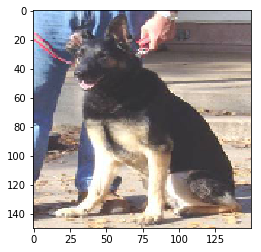

In [101]:
inp_len = 150
inp_wid = 150
inp_dep = 3

# number of classifiers i.e. outputs
n_class = 1

# network architecture
NetArch=[
        # input
        ('input',inp_dep,(inp_len,inp_wid)),
    
        # conv + max pool layers
        ('conv2d' ,  32,(3,3),'relu'),
        ('maxpool'),
        ('conv2d' ,  64,(3,3),'relu'),
        ('maxpool'),
        ('conv2d' , 128,(3,3),'relu'),
        # new
        ('conv2d' , 256,(5,5),'relu'),
        ('maxpool'),
    
        # flatten + fully connected
        ('flatten'),
        ('dense'  , 512,       'relu'),
        ('dense'  , n_class,  'sigmoid')
      ]
    
my_model_1 = VisionNet(NetArch,verbose=1)
my_model_1.SetupImageGen(num_train=2000,num_validation=1000,batch_size=50)
my_model_1.model_compile(loss='binary_crossentropy')
my_model_1.model_fit(epochs=20)

In [ ]:
# network architecture
NetArch2=[
        # input
        ('input',inp_dep,(inp_len,inp_wid)),
    
        # conv + max pool layers
        ('conv2d' ,  32,(3,3),'relu'),
        ('maxpool'),
        ('conv2d' ,  64,(3,3),'relu'),
        ('maxpool'),
        ('conv2d' , 128,(3,3),'relu'),
    
        # new
        ('conv2d' , 256,(3,3),'relu'),
        ('maxpool'),
    
        # dropout (new)
        ('dropout', 0.5),
    
        # flatten + fully connected
        ('flatten'),
        ('dense'  , 512,      'relu'),
        ('dense'  , n_class,  'sigmoid')
        ]
    
my_model_2 = VisionNet(NetArch2,verbose=1)
my_model_2.SetupImageGen(num_train=2000,num_validation=1000,batch_size=50)
my_model_2.model_compile(loss='binary_crossentropy')
my_model_2.model_fit(epochs=5)

INFO: resetting all nodes .. 
N/Net: Input len=150 wid=150 depth=3
CONV:: 32 (3, 3) relu
MAXP:: (2, 2)
CONV:: 64 (3, 3) relu
MAXP:: (2, 2)
CONV:: 128 (3, 3) relu
CONV:: 256 (3, 3) relu
MAXP:: (2, 2)
DROUPUT::0.500
FLAT::
DENS:: 512 relu
DENS:: 1 sigmoid
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
____________________